In [ ]:
# importing dependencies
import numpy as np
import pandas as pd
from math import sqrt
from collections import defaultdict

from pandas.tseries.holiday import USFederalHolidayCalendar
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose   
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import scale

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from datetime import datetime as dt

import warnings
import matplotlib.pyplot as plt
import pylab
warnings.filterwarnings("ignore")
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
calendar = pd.read_csv('/content/drive/MyDrive/Walmart Data/calendar.csv')
sales= pd.read_csv('/content/drive/MyDrive/Walmart Data/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/Walmart Data/sell_prices.csv')

In [ ]:
print("The shape of sales data:",sales.shape)
print("The shape of sell_prices data:",sell_prices.shape)
print("The shape of calender data:",calendar.shape)

The shape of sales data: (30490, 1947)
The shape of sell_prices data: (6841121, 4)
The shape of calender data: (1969, 14)


## Memory Downcast

In [ ]:
def checkMemUsage(df):
  """
  Helper function to check memory usage

  Input: A dataframe

  Output: Memory usage

  """
  mem_usage = df.memory_usage().sum()
  return np.round(np.round(mem_usage/(1024*1024),1))

In [ ]:
def performDowncast(df):

  """
  Function tpo apply downcasting 
  
  Input: A dataframe 

  Output: Dataframe with reduced memory usage
  
  
  """
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()

  for idx,dtype in enumerate(types):

      if 'int' in str(dtype):  # Downcasting for Int type variables
          if df[cols[idx]].min() > np.iinfo(np.int8).min and df[cols[idx]].max() < np.iinfo(np.int8).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int8) # Downsize to int8
          elif df[cols[idx]].min() > np.iinfo(np.int16).min and df[cols[idx]].max() < np.iinfo(np.int16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int16) # Downsize to int16
          elif df[cols[idx]].min() > np.iinfo(np.int32).min and df[cols[idx]].max() < np.iinfo(np.int32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int32) # Downsize to int32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.int64) # Downsize as int64

      elif 'float' in str(dtype): # Downcasting for Float type variables
          if df[cols[idx]].min() > np.finfo(np.float16).min and df[cols[idx]].max() < np.finfo(np.float16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float16) # Downsize to float16
          elif df[cols[idx]].min() > np.finfo(np.float32).min and df[cols[idx]].max() < np.finfo(np.float32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float32) # Downsize to float32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.float64) # Downsize to float64

      elif dtype == np.object: # By default strings are treated as objects
          if cols[idx] == 'date':
              df[cols[idx]] = pd.to_datetime(df[cols[idx]], format='%Y-%m-%d')
          # else:
          #     df[cols[idx]] = df[cols[idx]].astype('category')

  return df

In [ ]:
sales = performDowncast(sales)
calendar = performDowncast(calendar)
sell_prices = performDowncast(sell_prices)

print("Memory Usage after Downcasting: Sales {} , Calendar {} , sell_prices {}".format(checkMemUsage(sales), checkMemUsage(calendar), checkMemUsage(sell_prices)))

Memory Usage after Downcasting: Sales 96.0 , Calendar 0.0 , sell_prices 130.0


In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [ ]:
sales_item = sales.groupby('item_id').sum()
sales_item.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15.0,16,18,11.0,10.0,12.0,7.0,17.0,9,9.0,8.0,5,14.0,26.0,8.0,12.0,13,5.0,11.0,10.0,14.0,11.0,8,22,14.0,6.0,9.0,...,6.0,3,4,4,30,7.0,5.0,3.0,6.0,2,16,6,4,5.0,7.0,1.0,9,3,9.0,1.0,10,3.0,1.0,6,10,6,2.0,5.0,6.0,2.0,7,8,8,4.0,7.0,7.0,5.0,7.0,5,9.0
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5.0,8,5,1.0,3.0,2.0,0.0,4.0,5,4.0,2.0,2,4.0,3.0,5.0,7.0,3,3.0,4.0,7.0,7.0,3.0,4,11,0.0,1.0,1.0,...,5.0,4,5,9,4,1.0,3.0,5.0,5.0,3,3,1,9,4.0,3.0,4.0,5,7,2.0,5.0,6,3.0,2.0,4,5,3,1.0,6.0,3.0,10.0,5,8,7,2.0,6.0,5.0,0.0,6.0,6,4.0
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17.0,20,14,10.0,9.0,3.0,14.0,7.0,23,16.0,7.0,12,6.0,5.0,7.0,10.0,6,10.0,6.0,8.0,3.0,9.0,18,18,11.0,8.0,4.0,...,4.0,1,7,3,5,6.0,3.0,4.0,4.0,3,11,5,7,13.0,9.0,1.0,2,4,7.0,9.0,2,3.0,13.0,5,9,5,0.0,6.0,3.0,10.0,7,8,6,11.0,9.0,7.0,7.0,10.0,6,5.0
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,15.0,33.0,67.0,118,101,132.0,119.0,156,116.0,144.0,150,173,152,123.0,100.0,95.0,112.0,115,104,107,81.0,73.0,62.0,71.0,75.0,83,93.0
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,16,23,30,21.0,45,61,27.0,20.0,13.0,13.0,17.0,26,30.0,34.0,14,36.0,25.0,9.0,37.0,39,18.0,13.0,18.0,19.0,17.0,24,40,16.0,15.0,7.0,...,25.0,24,16,14,14,18.0,18.0,27.0,12.0,15,38,9,14,9.0,27.0,14.0,14,33,19.0,17.0,11,16.0,18.0,29,28,13,25.0,10.0,19.0,12.0,15,16,25,9.0,7.0,25.0,19.0,25.0,17,19.0


In [ ]:
sales_store = sales.groupby('store_id').sum()
sales_store.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078.0,4316,4354,2757.0,2430.0,2272.0,2009.0,3015.0,4553,3966.0,3264.0,2441,2377.0,2414.0,2701.0,3719.0,3548,2246.0,2549.0,2559.0,2568.0,2978.0,4096,4832,3138.0,2997.0,2772.0,...,3478.0,3637,3982,5437,5954,4345.0,3793.0,3722.0,3709.0,4387,5577,6113,4472,3703.0,3715.0,3618.0,4573,5898,6397.0,4794.0,4594,4234.0,3918.0,4804,6069,5212,4859.0,4104.0,3982.0,4049.0,4951,6245,6707,4568.0,3949.0,3995.0,4136.0,4433.0,5764,6289.0
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584.0,3455,3563,1801.0,1797.0,1741.0,1614.0,2214.0,3080,3087.0,2601.0,1810,1851.0,1652.0,2187.0,3516.0,2692,1894.0,1958.0,1837.0,2010.0,2105.0,3199,3272,1970.0,1800.0,2064.0,...,3545.0,3441,4440,5352,5760,3830.0,3631.0,3691.0,3303.0,4457,5884,6082,3926,3525.0,3527.0,3754.0,4382,6349,6193.0,4434.0,3977,4243.0,4020.0,4492,6636,5330,3999.0,4092.0,3722.0,3751.0,4839,6507,6710,4238.0,3963.0,3789.0,4037.0,4751.0,7120,6614.0
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380.0,5187,5780,3303.0,3758.0,3641.0,3099.0,3320.0,4694,4794.0,4631.0,3593,3342.0,3310.0,3575.0,4774.0,4540,3604.0,3846.0,3821.0,3757.0,3904.0,4894,5895,4274.0,4084.0,3754.0,...,5377.0,5493,5337,6936,8271,6068.0,5683.0,5235.0,5018.0,5623,7419,7721,6359,5289.0,5065.0,5015.0,5705,7057,7828.0,6776.0,6325,6204.0,5793.0,5842,7346,6743,6958.0,5960.0,5884.0,5039.0,6046,7029,7969,5891.0,5523.0,5375.0,5580.0,5542.0,7073,8144.0
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312.0,1652,1933,1183.0,1511.0,1190.0,1113.0,1476.0,1543,1618.0,1501.0,1286,1371.0,1138.0,1384.0,1643.0,1711,1452.0,1429.0,1320.0,1375.0,1457.0,1595,2058,1571.0,1418.0,1361.0,...,2214.0,2498,2496,2839,3047,2809.0,2677.0,2500.0,2458.0,2628,2954,3271,2767,2495.0,2529.0,2277.0,2520,3023,3271.0,3113.0,2934,2585.0,2466.0,2500,3068,2675,3100.0,2815.0,2603.0,2659.0,2635,3256,3318,3024.0,2715.0,2519.0,2544.0,2704.0,3146,3597.0
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256.0,2944,3432,1921.0,2217.0,1962.0,1821.0,1951.0,2571,2810.0,2071.0,1933,1723.0,1825.0,1886.0,2629.0,2688,1985.0,1967.0,1860.0,2052.0,1753.0,2642,3031,2272.0,1788.0,2180.0,...,2852.0,2924,3084,3724,4192,3410.0,3257.0,2901.0,2776.0,3022,3700,4033,3076,2853.0,2984.0,2664.0,3687,4052,4412.0,2859.0,3217,2839.0,3170.0,3428,4123,3196,3437.0,3020.0,3398.0,3351.0,3610,3787,5000,3708.0,3310.0,3147.0,2748.0,3664.0,4167,4624.0


In [ ]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178.0,3764.0,5689.0
d_2,22758.0,3357.0,5634.0
d_3,17174.0,2682.0,3927.0
d_4,18878.0,2669.0,3865.0
d_5,14603.0,1814.0,2729.0


In [ ]:
sales_dept = sales.groupby('dept_id').sum().T
sales_dept.head()

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
d_1,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0
d_2,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0
d_3,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0
d_4,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0
d_5,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0


In [ ]:
sales_cat['days'] = sales_cat.index
sales_cat

cat_id,FOODS,HOBBIES,HOUSEHOLD,days
d_1,23178.0,3764.0,5689.0,d_1
d_2,22758.0,3357.0,5634.0,d_2
d_3,17174.0,2682.0,3927.0,d_3
d_4,18878.0,2669.0,3865.0,d_4
d_5,14603.0,1814.0,2729.0,d_5
...,...,...,...,...
d_1937,24790.0,3740.0,8566.0,d_1937
d_1938,24737.0,3475.0,8751.0,d_1938
d_1939,28136.0,4143.0,10273.0,d_1939
d_1940,33599.0,5333.0,12586.0,d_1940


In [ ]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
## Filtering few columns from Calendar data -- these columns are not required further
sales_calender = calendar.iloc[:,[0,2,3,4,5,6,8,10,11,12,13]]  # Including all special day events
print(sales_calender.shape)
sales_calender.head(10)

(1969, 11)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1
5,2011-02-03,Thursday,6,2,2011,d_6,NaN,NaN,1,1,1
6,2011-02-04,Friday,7,2,2011,d_7,NaN,NaN,1,0,0
7,2011-02-05,Saturday,1,2,2011,d_8,NaN,NaN,1,1,1
8,2011-02-06,Sunday,2,2,2011,d_9,Sporting,NaN,1,1,1
9,2011-02-07,Monday,3,2,2011,d_10,NaN,NaN,1,1,0


## Merging Sales and Calendar Data

In [ ]:
## Merging Calendar with Sales Data
print(sales_cat.shape, sales_calender.shape)
sales_cat = pd.merge(sales_calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')
sales_cat['date'] = pd.to_datetime(sales_cat['date'])

(1941, 4) (1969, 11)


In [ ]:
print(sales_cat.shape)
sales_cat.head()

(1941, 15)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5


## Including US Federal Calendar Days

In [ ]:
sales_cat['Day_name'] = sales_cat.date.dt.day_name()
# sales_cat['Year'] = sales_cat.date.dt.year
sales_cat['Week'] = sales_cat.date.dt.week
sales_cat['Month'] = sales_cat.date.dt.month

# introducing variable for federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=sales_cat.date.min(), end=sales_cat.date.max()).to_pydatetime()
sales_cat['is_holiday'] = sales_cat[['date']].apply(lambda x: 1 if (x['date'] in holidays) else 0, axis = 1)

# # adding feature for weekend
# sales_cat['is_weekend'] = sales_cat[['Day_name']].apply(lambda x: 1 if (x['Day_name'] in ['Saturday', 'Sunday']) else 0, axis = 1)


# adding feature for working day or not
sales_cat['is_workingday'] = (sales_cat[['Day_name','is_holiday']]
                             .apply(lambda x: 1 if (x['Day_name'] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] and x['is_holiday'] == 0) else 0, axis = 1))

# changing the index to date
sales_cat.set_index('date', inplace=True)
sales_cat.head()

,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,,,,,,,,,
2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1,Saturday,4,1,0,0
2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2,Sunday,4,1,0,0
2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3,Monday,5,1,0,1
2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4,Tuesday,5,2,0,1
2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5,Wednesday,5,2,0,1


In [ ]:
sales_cat_s = sales_cat[['month','event_type_1','event_type_2',	
                           'snap_CA',	'snap_TX','snap_WI','Day_name','Week','Month',
                           'is_holiday','is_workingday']]
sales_cat_s['event_type_1'] = sales_cat_s['event_type_1'].fillna('Regular')
sales_cat_s['event_type_2'] = sales_cat_s['event_type_2'].fillna('Regular')


In [ ]:
sales_cat_s

,month,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,
2011-01-29,1,Regular,Regular,0,0,0,Saturday,4,1,0,0
2011-01-30,1,Regular,Regular,0,0,0,Sunday,4,1,0,0
2011-01-31,1,Regular,Regular,0,0,0,Monday,5,1,0,1
2011-02-01,2,Regular,Regular,1,1,0,Tuesday,5,2,0,1
2011-02-02,2,Regular,Regular,1,0,1,Wednesday,5,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,5,Regular,Regular,0,0,0,Wednesday,20,5,0,1
2016-05-19,5,Regular,Regular,0,0,0,Thursday,20,5,0,1
2016-05-20,5,Regular,Regular,0,0,0,Friday,20,5,0,1


In [ ]:
sales_cat_s.head()
sales_cat_s_copy = sales_cat_s.copy()
sales_cat_s.head()

,month,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,
2011-01-29,1,Regular,Regular,0,0,0,Saturday,4,1,0,0
2011-01-30,1,Regular,Regular,0,0,0,Sunday,4,1,0,0
2011-01-31,1,Regular,Regular,0,0,0,Monday,5,1,0,1
2011-02-01,2,Regular,Regular,1,1,0,Tuesday,5,2,0,1
2011-02-02,2,Regular,Regular,1,0,1,Wednesday,5,2,0,1


In [ ]:
sales_cat_s = pd.read_csv('/content/drive/MyDrive/Walmart Data/sales_cat_s.csv')
sales_cat = pd.read_csv('/content/drive/MyDrive/Walmart Data/sales_cat.csv')

In [ ]:
sales_cat = sales_cat.drop(['FOODS'], axis = 1)

In [ ]:
sales_cat = sales_cat.drop(['weekday','wday','month','d','event_type_1','event_type_2','days','Day_name','Week','is_holiday','is_workingday','Month'], axis =1)

In [ ]:
sales_cat.columns

Index(['date', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'HOBBIES',
       'HOUSEHOLD'],
      dtype='object')

In [ ]:
start_date = '2016-04-25'

In [ ]:

def plotSeries(inputData,lists=[""]):
  """
  Helper Function to plot Time Series

  Input:
    inputData: Resampled Dataframe
    lists: category/department names

  Output:
    Timeseries plot

  """
  for i in lists:
        fig = go.Figure(data = [
              go.Scatter(y = inputData[i],x = inputData[i].index,name = i)
        ])
        fig.update_layout(title_text=i)
        fig.show()

In [ ]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices


In [ ]:
def filter_data(df, category, start_date = start_date) :  
    df_category = df
    df_category[category] = sales_cat[category] 
    # df_category_dummies = pd.get_dummies(df_category, columns=['Day_name','event_type_1','event_type_2']) 
    y = df_category[category]
    x = df_category.drop(category,axis = 1)
    # st.write(x.columns)
    x = x.set_index('date') 
    start_forecast_date = start_date
    x_train = x[:start_forecast_date]
    x_test = x[start_forecast_date::]
    y_train = y.loc[:1913]
    y_test = y.loc[1913::]
    return x_train, y_train, x_test, y_test

In [ ]:
## Scaling the data is important for using Neural Networks as it improves training performance
## MinMax Scaling the data for improving performance 
def scaled_data(df):
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
  print(scaled_df.shape)
  return scaled_df

In [ ]:
plotSeries(sales_cat,["HOUSEHOLD"])

In [ ]:
res, detected_outliers = hampel_filter_forloop(sales_cat.HOUSEHOLD, 28)

In [ ]:
sales_cat.HOUSEHOLD = res
plotSeries(sales_cat,["HOUSEHOLD"])


## The outliers are now removed

## Removing Trend from the Data and Testing

In [ ]:
sales_cat_s

,date,month,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,Day_name,Week,Month,is_holiday,is_workingday,HOUSEHOLD
0,2011-01-29,1,Regular,Regular,0,0,0,Saturday,4,1,0,0,5689.0
1,2011-01-30,1,Regular,Regular,0,0,0,Sunday,4,1,0,0,5634.0
2,2011-01-31,1,Regular,Regular,0,0,0,Monday,5,1,0,1,3927.0
3,2011-02-01,2,Regular,Regular,1,1,0,Tuesday,5,2,0,1,3865.0
4,2011-02-02,2,Regular,Regular,1,0,1,Wednesday,5,2,0,1,2729.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,5,Regular,Regular,0,0,0,Wednesday,20,5,0,1,8566.0
1937,2016-05-19,5,Regular,Regular,0,0,0,Thursday,20,5,0,1,8751.0
1938,2016-05-20,5,Regular,Regular,0,0,0,Friday,20,5,0,1,10273.0
1939,2016-05-21,5,Regular,Regular,0,0,0,Saturday,20,5,0,0,12586.0


In [ ]:
sales_cat_filter = sales_cat_s[['date','snap_CA','snap_TX','snap_WI']]

In [ ]:
sales_cat_filter

,date,snap_CA,snap_TX,snap_WI
0,2011-01-29,0,0,0
1,2011-01-30,0,0,0
2,2011-01-31,0,0,0
3,2011-02-01,1,1,0
4,2011-02-02,1,0,1
...,...,...,...,...
1936,2016-05-18,0,0,0
1937,2016-05-19,0,0,0
1938,2016-05-20,0,0,0
1939,2016-05-21,0,0,0


In [ ]:
sales_cat.columns
sales_cat_s3 = sales_cat_s.copy()
sales_cat_3 = sales_cat.copy()

In [ ]:
## remove trend with difference - sales_cat_1

## remove trend with log - sales_cqat_2

## Try removing all the columns other then date and try. --FIRST removed majority of the columns and trying -- sales_cat_3

In [ ]:
#### APPROACH 3 without transformation and columns

## Filtering Data and splitting into test and train

In [ ]:
# X_train_f, X_test_f, Y_train_f, Y_test_f = filter_data(sales_cat_s, "FOODS")
# X_train_f.shape, X_test_f.shape, Y_train_f.shape, Y_test_f.shape

Index(['month', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month', 'is_holiday',
       'is_workingday', 'Day_name_Friday', 'Day_name_Monday',
       'Day_name_Saturday', 'Day_name_Sunday', 'Day_name_Thursday',
       'Day_name_Tuesday', 'Day_name_Wednesday', 'event_type_1_Cultural',
       'event_type_1_National', 'event_type_1_Regular',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_type_2_Cultural', 'event_type_2_Regular',
       'event_type_2_Religious'],
      dtype='object')


((1914, 23), (28, 23), (1914,), (28,))

In [ ]:
X_train_house, Y_train_house, X_test_house, Y_test_house = filter_data(sales_cat_filter, "HOUSEHOLD")
X_train_house.shape, X_test_house.shape, Y_train_house.shape, Y_test_house.shape

((1914, 3), (28, 3), (1914,), (28,))

In [ ]:
# X_train_hob, X_test_hob, Y_train_hob, Y_test_hob= filter_data(sales_cat_s, "HOBBIES")
# X_train_hob.shape, X_test_hob.shape, Y_train_hob.shape, Y_test_hob.shape

Index(['month', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month', 'is_holiday',
       'is_workingday', 'FOODS', 'HOUSEHOLD', 'Day_name_Friday',
       'Day_name_Monday', 'Day_name_Saturday', 'Day_name_Sunday',
       'Day_name_Thursday', 'Day_name_Tuesday', 'Day_name_Wednesday',
       'event_type_1_Cultural', 'event_type_1_National',
       'event_type_1_Regular', 'event_type_1_Religious',
       'event_type_1_Sporting', 'event_type_2_Cultural',
       'event_type_2_Regular', 'event_type_2_Religious'],
      dtype='object')


((1914, 25), (28, 25), (1914,), (28,))

In [ ]:
X_train_scale = scaled_data(X_train_house)
X_test_scale = scaled_data(X_test_house)
# Y_train_scale = scaled_data(Y_train_f)
# Y_test_scale = scaled_data(Y_test_f)


(1914, 3)
(28, 3)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(np.array(Y_train_house).reshape(-1,1))
train_Y = scaler.transform(np.array(Y_train_house).reshape(-1,1))
train_Y



array([[-0.46488294],
       [-0.474826  ],
       [-0.78342222],
       ...,
       [ 0.72087137],
       [ 0.75883576],
       [ 0.14417427]])

In [ ]:
scaler = scaler.fit(np.array(Y_test_house).reshape(-1,1))
test_Y = scaler.transform(np.array(Y_test_house).reshape(-1,1))
test_Y

array([[-0.56723063],
       [-0.82902939],
       [-1.        ],
       [-0.9173642 ],
       [ 0.17542297],
       [ 0.65592164],
       [ 0.76740873],
       [-0.23882458],
       [-0.10810329],
       [-0.69688335],
       [-0.67052538],
       [-0.4030276 ],
       [ 0.65307213],
       [-0.33428317],
       [-0.3745325 ],
       [-0.78023152],
       [-0.54229742],
       [-0.71077471],
       [-0.19786287],
       [ 0.77951915],
       [ 1.        ],
       [-0.34710597],
       [-0.58788958],
       [-0.74247551],
       [-0.67658059],
       [-0.13446126],
       [ 0.68940338],
       [ 0.86927872]])

## Plotting Y_train_f and Y_test_f to see the distribution and check whether they are stationary and have no outliers

No handles with labels found to put in legend.


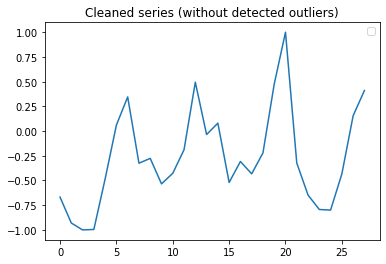

In [ ]:

plt.plot(np.arange(len(test_Y)), test_Y);
# plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
# plt.scatter(fp, rw[fp], c='r', label='false positive')
plt.title('Cleaned series (without detected outliers)')
plt.legend()

In [ ]:
## TRANSFORMING THE DATAFRAME INTO 3-D FEATURES as expected by LSTMs, namely [samples, timesteps, features].
def transform_df_LSTM(X_train, X_test, Y_train, Y_test):
  X_train_arr = np.array(X_train)
  X_test_arr = np.array(X_test)
  
  train_X = X_train_arr.reshape((X_train_arr.shape[0], 1, X_train_arr.shape[1]))
  test_X = X_test_arr.reshape((X_test_arr.shape[0], 1, X_test_arr.shape[1]))
  train_Y = np.array(Y_train).reshape(-1,1)
  print(train_Y)
  test_Y = np.array(Y_test).reshape(-1,1)
  print(test_Y)
  
  return train_X, test_X, train_Y, test_Y
  


In [ ]:
train_X.shape

(1914, 1, 3)

In [ ]:
train_X, test_X, train_Y,test_Y =  transform_df_LSTM(X_train_scale, X_test_scale, train_Y, test_Y)
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)


[[-0.46488294]
 [-0.474826  ]
 [-0.78342222]
 ...
 [ 0.72087137]
 [ 0.75883576]
 [ 0.14417427]]
[[-0.56723063]
 [-0.82902939]
 [-1.        ]
 [-0.9173642 ]
 [ 0.17542297]
 [ 0.65592164]
 [ 0.76740873]
 [-0.23882458]
 [-0.10810329]
 [-0.69688335]
 [-0.67052538]
 [-0.4030276 ]
 [ 0.65307213]
 [-0.33428317]
 [-0.3745325 ]
 [-0.78023152]
 [-0.54229742]
 [-0.71077471]
 [-0.19786287]
 [ 0.77951915]
 [ 1.        ]
 [-0.34710597]
 [-0.58788958]
 [-0.74247551]
 [-0.67658059]
 [-0.13446126]
 [ 0.68940338]
 [ 0.86927872]]
(1914, 1, 3) (1914, 1) (28, 1, 3) (28, 1)


In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
sales_cat.shape

(1941, 7)

In [ ]:
# multi-step data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = sales_cat['HOUSEHOLD']
# choose a number of time steps
n_steps_in, n_steps_out = 28, 28
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
  7066.  5940.  5850.  5821.  7384. 10378.  9897.  6877.  5948.  6205.
  6286.  7593.  9770.  9275.  6230.  6695.  7419.  3996.]
[11218. 11357.  7964.  7095.  6809.  6854.  7971. 10213. 10316.  7593.
  6586.  7333.  6358.  7799.  9863. 10004.  7317.  6592.  6588.  6749.
  7773.  9927.  9621.  7132.  6427.  6571.  5482.  9930.] [ 7325. 10190.  7046.  6883.  6250.  6567.  7393.  9830.  9941.  7066.
  5940.  5850.  5821.  7384. 10378.  9897.  6877.  5948.  6205.  6286.
  7593.  9770.  9275.  6230.  6695.  7419.  3996.  7432.]
[11357.  7964.  7095.  6809.  6854.  7971. 10213. 10316.  7593.  6586.
  7333.  6358.  7799.  9863. 10004.  7317.  6592.  6588.  6749.  7773.
  9927.  9621.  7132.  6427.  6571.  5482.  9930.  7325.] [10190.  7046.  6883.  6250.  6567.  7393.  9830.  9941.  7066.  5940.
  5850.  5821.  7384. 10378.  9897.  6877.  5948.  6205.  6286.  7593.
  9770.  9275.  6230.  6695.  7419.  3996.  7432.  8655.]
[ 7964.  7095.  6809

In [ ]:

...
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
y.shape

(1886, 28)

In [ ]:

...
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [ ]:
a

In [ ]:
model = Sequential()
model.add(LSTM(2000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(1000, return_sequences= True))
model.add(Dropout(0.1))
print(model.summary())
model.add(LSTM(500, return_sequences= True))
model.add(Dropout(0.1))
model.add(LSTM(250, return_sequences= True))

model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model)
# fit network
history = model.fit(train_X, train_Y, epochs=75, batch_size=64, validation_data=(test_X, test_Y), verbose=1, shuffle=False)
model.save('/content/drive/MyDrive/Walmart Data/LSTM_Household_App3')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 2000)           16032000  
                                                                 
 dropout (Dropout)           (None, 1, 2000)           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 1000)           12004000  
                                                                 
 dropout_1 (Dropout)         (None, 1, 1000)           0         
                                                                 
Total params: 28,036,000
Trainable params: 28,036,000
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/75
30/30 [==============================] - 26s 544ms/step - loss: 0.1677 - val_loss: 0.3947
Epoch 2/75
30/30 [==============================] - 14s 467ms/step - l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Household_App3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Household_App3/assets


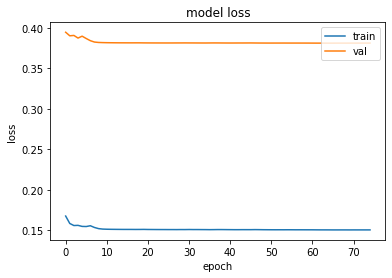

In [ ]:
 # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# make a prediction
y_predicted = model.predict(test_X, verbose=0)
rmse = np.sqrt(mean_squared_error(test_Y, y_predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.618


In [ ]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(test_Y), scaler.inverse_transform(y_predicted)))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1733.652


In [ ]:
# Plot both the actual data and forecasted data

def plot_results(category, test_Y, y_predicted):

  fig = plt.figure(figsize=(18,18))
  ax1 = fig.add_subplot(311)
  title = "Actual vs Predicted order_counts for "+category +" : LSTM Model"
  ax1.set_title(title)
  plt.plot(scaler.inverse_transform(test_Y), 'b-', label='actual')
  plt.plot(scaler.inverse_transform(y_predicted), 'r--', label='predicted')
  plt.xticks(rotation = 45)
  ax1.set_xlabel('Dates')
  ax1.set_ylabel('Differenced Order Counts')
  ax1.legend(loc='best')
  print(' ')
  print('LSTM Model - from {}'.format(start_date))
  print('='*50)
  print('R2 score on test data: {}'.format(r2_score(test_Y, y_predicted)))

  # Calculate the absolute error in the prediction vs actual number of trips
  abs_error = (test_Y - y_predicted)
  # Calculate the percentage error = absolute_error / actual trips
  percent_error = (abs_error / test_Y)

  rmse = np.sqrt(mean_squared_error(test_Y, y_predicted))

  print(' ')
  print('Average absolute error for {}: {}'.format(category,abs_error.mean()))
  print('RMSE for {}: {}'.format(category,rmse))
  print('Average percentage error for {}: {}'.format(category,percent_error.mean()))

 
LSTM Model - from 2016-04-25
R2 score on test data: -0.013679560662435364
 
Average absolute error for HOUSEHOLD: -0.07174985832284153
RMSE for HOUSEHOLD: 0.6175072396836251
Average percentage error for HOUSEHOLD: 0.8376133939508099


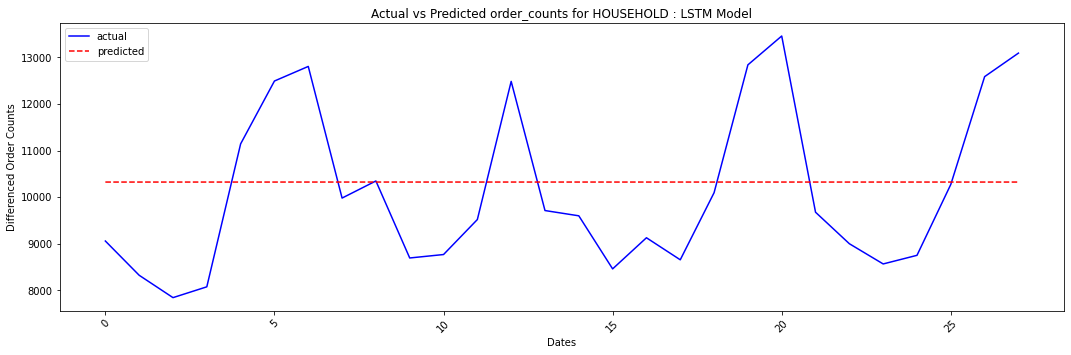

In [ ]:
plot_results("HOUSEHOLD", test_Y, y_predicted)

## HOBBIES Modeling

In [ ]:
# sales_cat_copy = sales_cat.copy()
sales_cat = sales_cat_copy.copy()

In [ ]:
plotSeries(sales_cat,["HOBBIES"])

In [ ]:
res_hob, detected_outliers = hampel_filter_forloop(sales_cat.HOBBIES, 28)
sales_cat.HOBBIES = res_hob.diff(2)
plotSeries(sales_cat,["HOBBIES"])

In [ ]:
sales_cat_s = sales_cat_s.iloc[2:]
sales_cat.HOBBIES = sales_cat.HOBBIES.dropna()

(1939, 13)

In [ ]:
X_train_hob, X_test_hob, Y_train_hob, Y_test_hob = filter_data(sales_cat_sn, "HOBBIES")
X_train_hob.shape, X_test_hob.shape, Y_train_hob.shape, Y_test_hob.shape

Index(['month', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month', 'is_holiday',
       'is_workingday', 'HOUSEHOLD', 'Day_name_Friday', 'Day_name_Monday',
       'Day_name_Saturday', 'Day_name_Sunday', 'Day_name_Thursday',
       'Day_name_Tuesday', 'Day_name_Wednesday', 'event_type_1_Cultural',
       'event_type_1_National', 'event_type_1_Regular',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_type_2_Cultural', 'event_type_2_Regular',
       'event_type_2_Religious'],
      dtype='object')


((1912, 24), (28, 24), (1912,), (28,))

In [ ]:
X_hob_train_scale = scaled_data(X_train_hob)
X_hob_test_scale = scaled_data(X_test_hob)

(1912, 24)
(28, 24)


In [ ]:
Y_test_arr = np.array(Y_test_hob)

Y_test_hob = np.array(Y_test_arr).reshape(-1,1)
scaler = scaler.fit(Y_test_hob)
test_Y_hob = scaler.transform(Y_test_hob)
print(test_Y_hob)

Y_train_arr = np.array(Y_train_hob)
Y_train_hob = np.array(Y_train_arr).reshape(-1,1)
scaler = scaler.fit(Y_train_hob)
train_Y_hob = scaler.transform(Y_train_hob)
print(train_Y_hob)

[[-0.76456086]
 [-0.78489985]
 [-0.17719569]
 [-0.0853621 ]
 [ 0.07365177]
 [ 0.76209553]
 [ 0.33127889]
 [-0.85701079]
 [-0.4440678 ]
 [-0.3614792 ]
 [-0.49707242]
 [-0.03975347]
 [ 0.59506934]
 [-0.03235747]
 [-0.82804314]
 [-0.43728814]
 [-0.19322034]
 [-0.07241911]
 [-0.11186441]
 [ 0.58644068]
 [ 0.5605547 ]
 [-0.98644068]
 [-1.        ]
 [-0.01448382]
 [-0.24006163]
 [ 0.10323575]
 [ 1.        ]
 [ 0.55562404]]
[[-0.55748792]
 [-0.36714976]
 [-0.45410628]
 ...
 [ 0.65797101]
 [ 0.25410628]
 [-0.52028986]]


In [ ]:
htrain_X, htest_X, htrain_Y, htest_Y =  transform_df_LSTM(X_hob_train_scale, X_hob_test_scale, train_Y_hob, test_Y_hob)
print(htrain_X.shape, htrain_Y.shape, htest_X.shape, htest_Y.shape)


[[-0.55748792]
 [-0.36714976]
 [-0.45410628]
 ...
 [ 0.65797101]
 [ 0.25410628]
 [-0.52028986]]
[[-0.76456086]
 [-0.78489985]
 [-0.17719569]
 [-0.0853621 ]
 [ 0.07365177]
 [ 0.76209553]
 [ 0.33127889]
 [-0.85701079]
 [-0.4440678 ]
 [-0.3614792 ]
 [-0.49707242]
 [-0.03975347]
 [ 0.59506934]
 [-0.03235747]
 [-0.82804314]
 [-0.43728814]
 [-0.19322034]
 [-0.07241911]
 [-0.11186441]
 [ 0.58644068]
 [ 0.5605547 ]
 [-0.98644068]
 [-1.        ]
 [-0.01448382]
 [-0.24006163]
 [ 0.10323575]
 [ 1.        ]
 [ 0.55562404]]
(1912, 1, 24) (1912, 1) (28, 1, 24) (28, 1)


In [ ]:
model = Sequential()
model.add(LSTM(2000, return_sequences=True, input_shape=(htrain_X.shape[1], htrain_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(1000, return_sequences= True))
model.add(Dropout(0.1))
print(model.summary())
model.add(LSTM(500, return_sequences= True))
model.add(Dropout(0.1))
model.add(LSTM(250, return_sequences= True))

model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(htrain_X, htrain_Y, epochs=5, batch_size=30, validation_data=(htest_X, htest_Y), verbose=1, shuffle=False)
model.save('/content/drive/MyDrive/Walmart Data/LSTM_Hobbies')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1, 2000)           16200000  
                                                                 
 dropout_18 (Dropout)        (None, 1, 2000)           0         
                                                                 
 lstm_30 (LSTM)              (None, 1, 1000)           12004000  
                                                                 
 dropout_19 (Dropout)        (None, 1, 1000)           0         
                                                                 
Total params: 28,204,000
Trainable params: 28,204,000
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
64/64 [==============================] - 31s 352ms/step - loss: 0.0524 - val_loss: 0.0508
Epoch 2/5
64/64 [==============================] - 20s 317ms/step - l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Hobbies/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Hobbies/assets


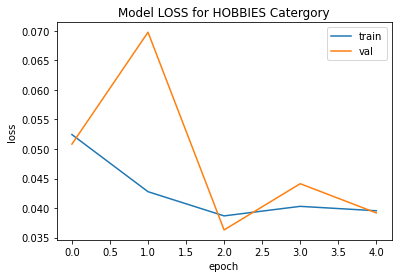

In [ ]:
 # summarize history for loss for HOBBIES category
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model LOSS for HOBBIES Catergory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# make a prediction
hy_predicted = model.predict(htest_X, verbose=0)
rmse = np.sqrt(mean_squared_error(htest_Y, hy_predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.198


In [ ]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(htest_Y), scaler.inverse_transform(hy_predicted)))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 409.770


 
LSTM Model - from 2016-04-25
R2 score on test data: 0.8651832539233901
 
Average absolute error for HOBBIES: -0.05763089454747387
RMSE for HOBBIES: 0.19795661291379318
Average percentage error for HOBBIES: -0.2581838278113998


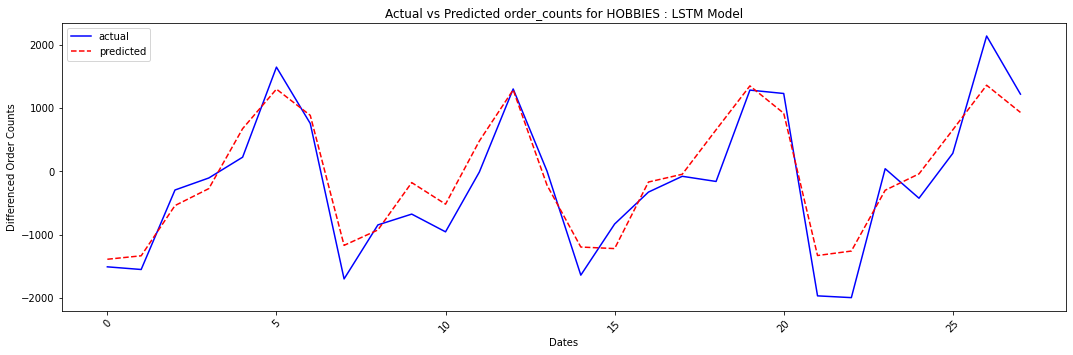

In [ ]:
plot_results("HOBBIES", htest_Y, hy_predicted)

## HOUSEHOLD CATEGORY PREDICTIONS

In [ ]:
sales_cat_copy = sales_cat.copy()

In [ ]:
plotSeries(sales_cat,["HOUSEHOLD"])

In [ ]:
res_hob, detected_outliers = hampel_filter_forloop(sales_cat.HOUSEHOLD, 28)
sales_cat.HOUSEHOLD = res_hob
plotSeries(sales_cat,["HOUSEHOLD"])

In [ ]:
X_train_house, X_test_house, Y_train_house, Y_test_house = filter_data(sales_cat_s, "HOUSEHOLD")
X_train_house.shape, X_test_house.shape, Y_train_house.shape, Y_test_house.shape

Index(['month', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month', 'is_holiday',
       'is_workingday', 'HOBBIES', 'Day_name_Friday', 'Day_name_Monday',
       'Day_name_Saturday', 'Day_name_Sunday', 'Day_name_Thursday',
       'Day_name_Tuesday', 'Day_name_Wednesday', 'event_type_1_Cultural',
       'event_type_1_National', 'event_type_1_Regular',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_type_2_Cultural', 'event_type_2_Regular',
       'event_type_2_Religious'],
      dtype='object')


((1914, 24), (28, 24), (1914,), (28,))

In [ ]:
X_hold_train_scale = scaled_data(X_train_house)
X_hold_test_scale = scaled_data(X_test_house)

(1914, 24)
(28, 24)


In [ ]:
Y_test_arr = np.array(Y_test_house)

Y_test_house = np.array(Y_test_arr).reshape(-1,1)
scaler = scaler.fit(Y_test_house)
test_Y_house = scaler.transform(Y_test_house)
print(test_Y_house)

Y_train_arr = np.array(Y_train_house)
Y_train_house = np.array(Y_train_arr).reshape(-1,1)
scaler = scaler.fit(Y_train_house)
train_Y_house = scaler.transform(Y_train_house)
print(train_Y_house)

[[-0.56723063]
 [-0.82902939]
 [-1.        ]
 [-0.9173642 ]
 [ 0.17542297]
 [ 0.65592164]
 [ 0.76740873]
 [-0.23882458]
 [-0.10810329]
 [-0.69688335]
 [-0.67052538]
 [-0.4030276 ]
 [ 0.65307213]
 [-0.33428317]
 [-0.3745325 ]
 [-0.78023152]
 [-0.54229742]
 [-0.71077471]
 [-0.19786287]
 [ 0.77951915]
 [ 1.        ]
 [-0.34710597]
 [-0.58788958]
 [-0.74247551]
 [-0.67658059]
 [-0.13446126]
 [ 0.68940338]
 [ 0.86927872]]
[[-0.46488294]
 [-0.474826  ]
 [-0.78342222]
 ...
 [ 0.72087137]
 [ 0.75883576]
 [ 0.14417427]]


In [ ]:
dtrain_X, dtest_X, dtrain_Y, dtest_Y =  transform_df_LSTM(X_hold_train_scale, X_hold_test_scale, train_Y_house, test_Y_house)
print(dtrain_X.shape, dtrain_Y.shape, dtest_X.shape, dtest_Y.shape)

[[-0.46488294]
 [-0.474826  ]
 [-0.78342222]
 ...
 [ 0.72087137]
 [ 0.75883576]
 [ 0.14417427]]
[[-0.56723063]
 [-0.82902939]
 [-1.        ]
 [-0.9173642 ]
 [ 0.17542297]
 [ 0.65592164]
 [ 0.76740873]
 [-0.23882458]
 [-0.10810329]
 [-0.69688335]
 [-0.67052538]
 [-0.4030276 ]
 [ 0.65307213]
 [-0.33428317]
 [-0.3745325 ]
 [-0.78023152]
 [-0.54229742]
 [-0.71077471]
 [-0.19786287]
 [ 0.77951915]
 [ 1.        ]
 [-0.34710597]
 [-0.58788958]
 [-0.74247551]
 [-0.67658059]
 [-0.13446126]
 [ 0.68940338]
 [ 0.86927872]]
(1914, 1, 24) (1914, 1) (28, 1, 24) (28, 1)


In [ ]:
model = Sequential()
model.add(LSTM(2000, return_sequences=True, input_shape=(dtrain_X.shape[1], dtrain_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(1000, return_sequences= True))
model.add(Dropout(0.1))
model.add(LSTM(500, return_sequences= True))
model.add(Dropout(0.1))
# model.add(LSTM(250, return_sequences= True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(dtrain_X, dtrain_Y, epochs=75, batch_size=64, validation_data=(dtest_X, dtest_Y), verbose=1, shuffle=False)
model.save('/content/drive/MyDrive/Walmart Data/LSTM_Household')

Epoch 1/100
48/48 [==============================] - 23s 335ms/step - loss: 0.0539 - val_loss: 0.3415
Epoch 2/100
48/48 [==============================] - 14s 294ms/step - loss: 0.0910 - val_loss: 0.3304
Epoch 3/100
48/48 [==============================] - 14s 295ms/step - loss: 0.0666 - val_loss: 0.3450
Epoch 4/100
48/48 [==============================] - 14s 297ms/step - loss: 0.0761 - val_loss: 0.6873
Epoch 5/100
48/48 [==============================] - 14s 296ms/step - loss: 0.1334 - val_loss: 0.5631
Epoch 6/100
48/48 [==============================] - 14s 297ms/step - loss: 0.1269 - val_loss: 0.4526
Epoch 7/100
48/48 [==============================] - 14s 299ms/step - loss: 0.1031 - val_loss: 0.4581
Epoch 8/100
48/48 [==============================] - 14s 298ms/step - loss: 0.1031 - val_loss: 0.4607
Epoch 9/100
48/48 [==============================] - 14s 298ms/step - loss: 0.1031 - val_loss: 0.4617
Epoch 10/100
48/48 [==============================] - 14s 300ms/step - loss: 0.103

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Household/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Walmart Data/LSTM_Household/assets


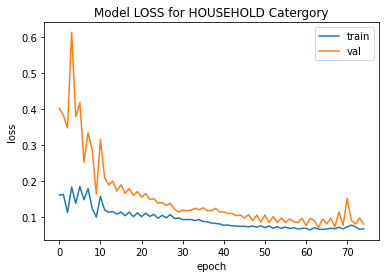

In [ ]:
 # summarize history for loss for HOBBIES category
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model LOSS for HOUSEHOLD Catergory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# make a prediction
dy_predicted = model.predict(dtest_X, verbose=0)
rmse = np.sqrt(mean_squared_error(dtest_Y, dy_predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.285


In [ ]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(dtest_Y), scaler.inverse_transform(dy_predicted)))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1577.182


 
LSTM Model - from 2016-04-25
R2 score on test data: 0.7838803521176867
 
Average absolute error for HOUSEHOLD: -0.1979995521891285
RMSE for HOUSEHOLD: 0.2851273215897118
Average percentage error for HOUSEHOLD: 0.48570973824101177


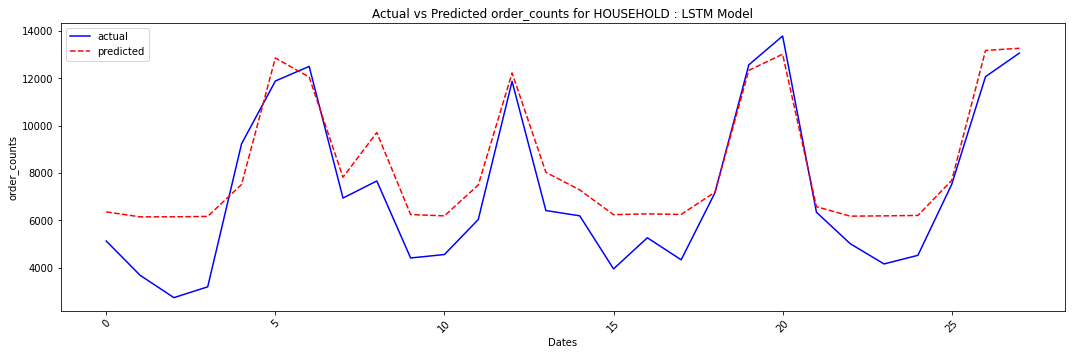

In [ ]:
plot_results("HOUSEHOLD", dtest_Y, dy_predicted)